In [10]:
import pandas as pd
import numpy as np

def nuts_filter(df):
    """
    Keep only articles that have at least one German NUTS code (starting with 'DE'),
    and collapse to one row per article id, with NUTS being a comma-separated string of German NUTS codes.
    """
    df = df.copy()
    
    df["NUTS"] = df["NUTS"].fillna("").astype(str)

    df_nuts_combined = (
        df.groupby("id").agg({
            "NUTS": lambda x: ", ".join(sorted({code for code in x if code.startswith("DE")})),
            "url": "first",
            "date": "first",
            "cos_dist": "first",
            "loc_normal": "first",
            "latitude": "first",
            "longitude": "first",
        })
        .reset_index()
    )

    return df_nuts_combined[df_nuts_combined["NUTS"] != ""]


def date_filter(df, start_year, end_year):
    """
    Keep only articles that are between certain years
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df[
        (df["date"].dt.year >= start_year) &
        (df["date"].dt.year <= end_year)
    ].copy()

file_path = "/Users/zoekirsman/Desktop/femicide_29-32/500000_32_homicide-female_DE.csv"
df = pd.read_csv(file_path)

print("Original rows:", len(df))

df = nuts_filter(df)
print("Rows after German NUTS filter:", len(df))

df = date_filter(df, 2017, 2023)
print("Rows after date filter (2017–2023):", len(df))

print("\nAfter filtering:")
print("Unique IDs:", df["id"].nunique())
print("Total rows:", len(df))
print("Year range:", df["date"].dt.year.min(), "to", df["date"].dt.year.max())

print("\nSample NUTS values:")
print(df["NUTS"].head(10))

# save filtered dataset
filtered_out = "/Users/zoekirsman/Desktop/filtered_query32_articles.csv"
df.to_csv(filtered_out, index=False)
print("\nSaved filtered dataset to:", filtered_out)

# stratified sampling
print("\nSampling")
min_cos = df["cos_dist"].min()
print("Min cos_dist:", min_cos)
max_cos = df["cos_dist"].max()
print("Max cos_dist:", max_cos)
bins = np.arange(0.16, 0.29, 0.02)  # 0.16, 0.17,..., 0.28

df["cosine_bin"] = pd.cut(df["cos_dist"], bins=bins, right=True)

print("Articles per cosine bin:")
bin_counts = df["cosine_bin"].value_counts().sort_index()
print(bin_counts)

SAMPLES_PER_BIN = 150
samples = []
per_bin_taken = {}

for b in df["cosine_bin"].cat.categories:
    articles_in_bin = df[df["cosine_bin"] == b]
    n = min(SAMPLES_PER_BIN, len(articles_in_bin))
    per_bin_taken[str(b)] = n
    samples.append(articles_in_bin.sample(n, random_state=42))

label_df = pd.concat(samples).reset_index(drop=True)

for b in df["cosine_bin"].cat.categories:
    b_str = str(b)
    available = bin_counts[b]
    taken = per_bin_taken[b_str]
    print(f"{b_str}: available={available}, taken={taken}")

print("\nTotal sampled:", len(label_df))

# save samples dataset for manual tagging
label_df = label_df[["id", "url", "NUTS", "cos_dist", "cosine_bin"]]
out_path = "/Users/zoekirsman/Desktop/samples_manual_tagging.csv"
label_df.to_csv(out_path, index=False)
print("\nSaved labeling CSV to:", out_path)

Original rows: 1143913
Rows after German NUTS filter: 375215
Rows after date filter (2017–2023): 364570

After filtering:
Unique IDs: 364570
Total rows: 364570
Year range: 2017 to 2023

Sample NUTS values:
0            DEF08, DEF0E
1     DEA12, DEA1F, DEA34
2                   DE300
3     DE222, DE914, DEB1B
4            DEA47, DEA5B
5                   DE300
6            DE212, DEA22
8            DE261, DE264
9            DEB31, DEB3I
10    DE718, DE71E, DE721
Name: NUTS, dtype: object

Saved filtered dataset to: /Users/zoekirsman/Desktop/filtered_query32_articles.csv

Sampling
Min cos_dist: 0.16486917
Max cos_dist: 0.2714406
Articles per cosine bin:
cosine_bin
(0.16, 0.18]        20
(0.18, 0.2]       2110
(0.2, 0.22]      19062
(0.22, 0.24]     57751
(0.24, 0.26]    135993
(0.26, 0.28]    149634
Name: count, dtype: int64
(0.16, 0.18]: available=20, taken=20
(0.18, 0.2]: available=2110, taken=150
(0.2, 0.22]: available=19062, taken=150
(0.22, 0.24]: available=57751, taken=150
(0.24, 0

In [3]:
import pandas as pd

# load 
lab = pd.read_csv("/Users/zoekirsman/Desktop/manual_tagging-query32_checked_articles.csv")

# clean label column
lab["woman_murdered"] = (
    lab["woman_murdered"]
    .astype(str) 
    .str.strip() 
    .str.upper() 
)

# keep only TRUE/FALSE rows (drop unusable samples, i.e., rows where woman_murdered was left blank)
print("Total samples:", len(lab))
lab = lab[lab["woman_murdered"].isin(["TRUE", "FALSE"])]
print("Number of usable samples:", len(lab))
# convert TRUE/FALSE → 1/0
lab["woman_murdered"] = (lab["woman_murdered"] == "TRUE").astype(int) 

# compute summary table
summary = lab.groupby("cosine_bin").agg(
    n=("woman_murdered", "count"),
    relevance_rate=("woman_murdered", "mean") # number of TRUE samples / total samples
)

summary.sort_index()



Total samples: 770
Number of usable samples: 677


,n,relevance_rate
cosine_bin,,
"(0.16, 0.18]",20,1.000000
"(0.18, 0.2]",136,0.992647
"(0.2, 0.22]",131,0.923664
"(0.22, 0.24]",130,0.753846
"(0.24, 0.26]",128,0.320312
"(0.26, 0.28]",132,0.136364


In [4]:
import numpy as np

# define narrower bin edges
edges = np.arange(0.16, 0.29, 0.01)  # 0.16, 0.17,..., 0.28

# add parameter that says what bin it belongs to
lab["cosine_bin2"] = pd.cut(
    lab["cos_dist"],
    bins=edges,
    right=True,     # (a, b]
)
# compute summary table
summary = lab.groupby("cosine_bin2", observed=True).agg(
    n=("woman_murdered", "count"),
    relevance_rate=("woman_murdered", "mean") # number of TRUE samples / total samples
)

summary.sort_index()

,n,relevance_rate
cosine_bin2,,
"(0.16, 0.17]",2,1.000000
"(0.17, 0.18]",18,1.000000
"(0.18, 0.19]",14,1.000000
"(0.19, 0.2]",122,0.991803
"(0.2, 0.21]",36,0.972222
"(0.21, 0.22]",95,0.905263
"(0.22, 0.23]",54,0.870370
"(0.23, 0.24]",76,0.671053
"(0.24, 0.25]",59,0.491525


In [5]:
# load full dataset
full = pd.read_csv("/Users/zoekirsman/Desktop/filtered_query32_articles.csv")

# define bin edges
edges = np.arange(0.16, 0.29, 0.02)  # 0.16, 0.18, 0.20, ..., 0.28

# add parameter for cosine bin
full["cosine_bin"] = pd.cut(
    full["cos_dist"],   
    bins=edges,
    right=True,
)
lab["cosine_bin"] = pd.cut(
    lab["cos_dist"],
    bins=edges,
    right=True,
)

# sample stats
samples_stats = lab.groupby("cosine_bin", observed=True).agg(
    n=("woman_murdered", "count"),
    relevance_rate=("woman_murdered", "mean"),
)

# population stats
pop_stats = full.groupby("cosine_bin", observed=True).agg(
    n=("id", "count"),
)
pop_stats["relevance_estimate"] = samples_stats["relevance_rate"]
print(pop_stats)

# thresholds to evaluate
thresholds = np.arange(0.20, 0.251, 0.005) # 0.20, 0.25,..., 0.245, 0.25

def estimate_relevance_for_thresholds(lab):
    results = []
    for t in thresholds:
        # articles up to threshold t
        articles_included = full[full["cos_dist"] <= t] 
        n_articles_included = len(articles_included)

        # number of articles per bin, where the last bin is a subinterval of the last cosine_bin 
        counts_per_bin = articles_included.groupby("cosine_bin", observed=True).size()
        last_cos_bin = counts_per_bin.index[-1] #(x, y]
        new_last_bin = pd.Interval(left=last_cos_bin.left, right=t, closed="right") #(x, t]
        new_index = list(counts_per_bin.index[:-1]) + [new_last_bin]
        counts_per_bin.index = pd.Index(new_index)
        counts_per_bin = counts_per_bin.rename_axis("counts_per_bin")

        # estimated relevance rate per bin, use sample rate for all but last bin, and compute last rate
        est_rel_rate_per_bin = pd.Series(index=counts_per_bin.index, dtype=float)
        all_but_last_bin = counts_per_bin.index[:-1] 
        for b in all_but_last_bin:
            samples_in_bin = lab[lab["cosine_bin"] == b]
            est_rel_rate_per_bin.loc[b] = samples_in_bin["woman_murdered"].mean()
        samples_in_last_bin = lab[(lab["cosine_bin"] == last_cos_bin) & (lab["cos_dist"] <= t)]
        est_rel_rate_per_bin.loc[new_last_bin] = samples_in_last_bin["woman_murdered"].mean()

        # weighted sum: r1*c1 + r2*c2 + ... / c1 + c2 + ...
        est_true_per_bin = counts_per_bin * est_rel_rate_per_bin
        relevance_estimate = est_true_per_bin.sum() / n_articles_included

        results.append({
            "threshold": t,
            "dataset_size": n_articles_included,
            "relevance_estimate": relevance_estimate
        })
    return pd.DataFrame(results)

print("\nPrecision estimates (no CI yet):")
table = estimate_relevance_for_thresholds(lab)
print(table)



                   n  relevance_estimate
cosine_bin                              
(0.16, 0.18]      20            1.000000
(0.18, 0.2]     2110            0.992647
(0.2, 0.22]    19062            0.923664
(0.22, 0.24]   57751            0.753846
(0.24, 0.26]  135993            0.320312
(0.26, 0.28]  149634            0.136364

Precision estimates (no CI yet):
    threshold  dataset_size  relevance_estimate
0       0.200          2130            0.992716
1       0.205          4370            0.996450
2       0.210          7815            0.977808
3       0.215         13351            0.966512
4       0.220         21192            0.930605
5       0.225         31368            0.910803
6       0.230         44232            0.899229
7       0.235         59803            0.839108
8       0.240         78943            0.801296
9       0.245        102474            0.762727
10      0.250        132083            0.676668


In [6]:
# stratified bootstrap
B = 5000 # number of bootstrap replications
boot_results = {t: [] for t in thresholds}  # store relevance estimates per threshold

for b in range(B):
    # for each bin, resample the same number of rows with replacement
    boot_lab = lab.groupby("cosine_bin", observed=True, group_keys=False).sample(frac=1.0, replace=True)

    boot_df = estimate_relevance_for_thresholds(boot_lab)

    # store the bootstrap relevance estimates per threshold 
    for _, row in boot_df.iterrows():
        t = row["threshold"]
        boot_results[t].append(row["relevance_estimate"])

for t in thresholds:
    relevance_estimates_for_t = np.array(boot_results[t])

    # 95% percentile interval
    ci_low = np.percentile(relevance_estimates_for_t, 2.5)
    ci_high = np.percentile(relevance_estimates_for_t, 97.5)

    # add to table
    table.loc[table["threshold"] == t, "ci_low_95"] = ci_low
    table.loc[table["threshold"] == t, "ci_high_95"] = ci_high

print("\nPrecision estimates with 95% bootstrap CI:")
print(table)




Precision estimates with 95% bootstrap CI:
    threshold  dataset_size  relevance_estimate  ci_low_95  ci_high_95
0       0.200          2130            0.992716   0.978148    1.000000
1       0.205          4370            0.996450   0.989349    1.000000
2       0.210          7815            0.977808   0.929898    1.000000
3       0.215         13351            0.966512   0.925313    0.998838
4       0.220         21192            0.930605   0.888674    0.965668
5       0.225         31368            0.910803   0.852600    0.958790
6       0.230         44232            0.899229   0.845766    0.943998
7       0.235         59803            0.839108   0.781059    0.892269
8       0.240         78943            0.801296   0.745121    0.853985
9       0.245        102474            0.762727   0.704527    0.819832
10      0.250        132083            0.676668   0.615168    0.737311


In [7]:
# we choose 0.225 as our threshold

full = pd.read_csv("/Users/zoekirsman/Desktop/filtered_query32_articles.csv")

t = 0.225
articles_included = full[full["cos_dist"] <= t] 

out_path = "/Users/zoekirsman/Desktop/final_dataset_t225.csv"
articles_included.to_csv(out_path, index=False)

print(f"Saved final dataset ({len(articles_included)} articles) to: {out_path}")

Saved final dataset (31368 articles) to: /Users/zoekirsman/Desktop/final_dataset_t225.csv


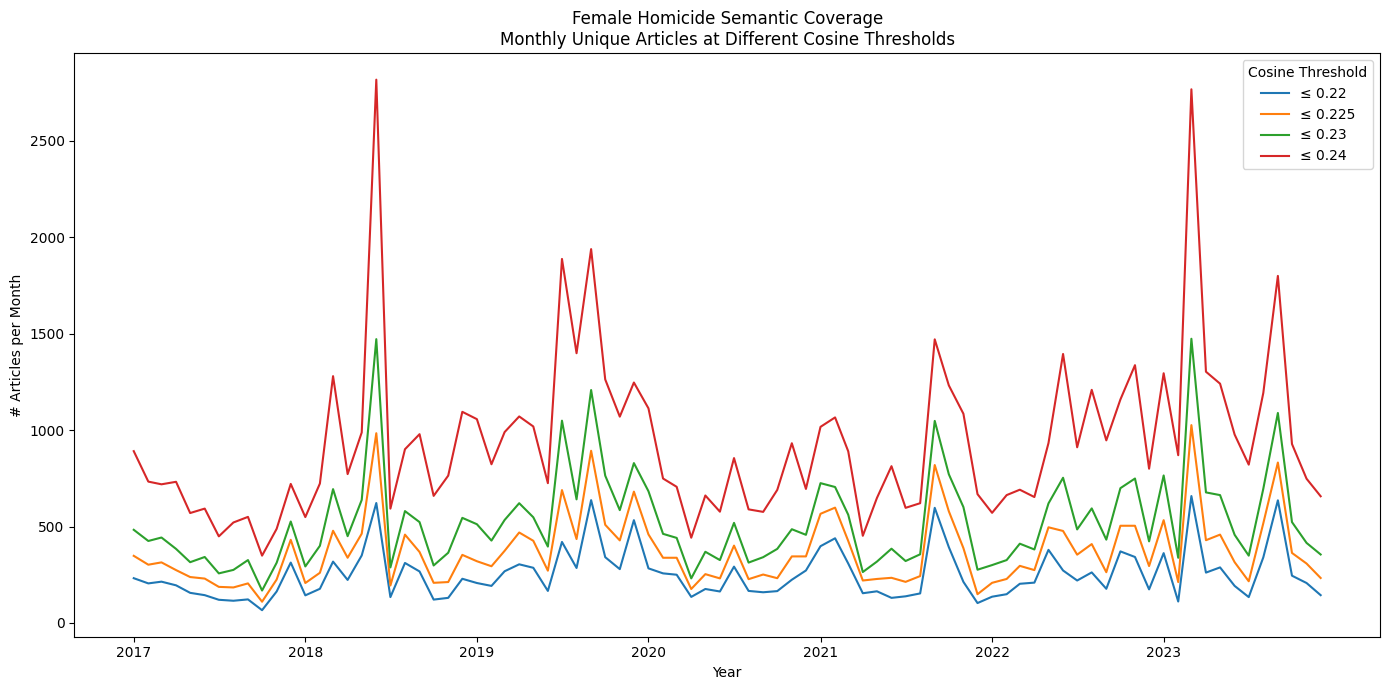

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/Users/zoekirsman/Desktop/filtered_query32_articles.csv")

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df[df["date"].notna()].drop_duplicates("id")
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

thresholds = [0.22, 0.225, 0.23, 0.24]

plt.figure(figsize=(14,7))

for t in thresholds:
    tmp = df[df["cos_dist"] <= t]
    monthly = tmp.groupby("month")["id"].nunique().sort_index()

    # reindex to continuous monthly index
    full = monthly.asfreq("MS")

    # interpolate for smoother curve (does not change peak heights)
    smooth = full.interpolate(method="linear")

    plt.plot(smooth.index, smooth.values, label=f"≤ {t}")

plt.title("Female Homicide Semantic Coverage\nMonthly Unique Articles at Different Cosine Thresholds")
plt.ylabel("# Articles per Month")
plt.xlabel("Year")

# show years on x axis
plt.xticks(
    [d for d in smooth.index if d.month == 1],
    [d.year for d in smooth.index if d.month == 1]
)

plt.legend(title="Cosine Threshold")
plt.tight_layout()
plt.savefig("/Users/zoekirsman/Desktop/monthly_threshold_interpolated.png")
plt.show()

In [9]:
import pandas as pd

import sys
print(sys.executable)

import plotly
import plotly.express as px

# Load filtered dataset (unique articles already)
df = pd.read_csv("/Users/zoekirsman/Desktop/filtered_query32_articles.csv")

# Parse date and keep valid
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df[df["date"].notna()]

# Make sure it's unique per article id
df = df.drop_duplicates("id")

# Extract year-month
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

# thresholds to compare
thresholds = [0.22, 0.225, 0.23, 0.24]

rows = []

for t in thresholds:
    tmp = df[df["cos_dist"] <= t]
    monthly_counts = (
        tmp.groupby("month")["id"]
           .nunique()
           .sort_index()
    )
    
    for m, c in monthly_counts.items():
        rows.append({
            "month": m,
            "articles": c,
            "threshold": f"≤ {t}"
        })

plotdf = pd.DataFrame(rows)

# Make interactive line plot
fig = px.line(
    plotdf,
    x="month",
    y="articles",
    color="threshold",
    markers=True,
    title="Female Homicide Coverage — Monthly Unique Articles",
    labels={
        "month": "Month",
        "articles": "Unique articles per month",
        "threshold": "Cosine threshold"
    }
)

# Optional: nicer hover info
fig.update_traces(
    hovertemplate="Month: %{x|%Y-%m}<br>Articles: %{y}<br>Threshold: %{legendgroup}"
)

fig.show()

/Users/zoekirsman/femicide_env/bin/python
